After reusing the existing code to prepare and fit additional supervised models to our training data, I was surprised by the results: Each of the models that I tried would result in extremely strong performance on the training data as well as the validation data. If we were overfitting on the training data, the model performance on the test data should be relatively poor. However, it was performing well on the test data too. Still, I was concerned because the results seemed too good to be true. I'm fairly confident that were were introducing ["data leakage"](https://towardsdatascience.com/data-leakage-in-machine-learning-how-it-can-be-detected-and-minimize-the-risk-8ef4e3a97562) with the original process.

What we were doing wrong was this: We were passing the full dataset into the normalizeData() function before splitting it into train and test sets. By doing this, we were "leaking" information from the testing set into the training set because the full set is being used for calculations and aggregations. As a result, the model gets some information about the distribution of the testing set during training. We were giving the model a peak of the real answers in an indirect way, resulting in overfitting on the testing data.

To fix the data leak, we can split the dataset into training and testing sets and run the normalization function on the sets separately. The testing set remains unseen, which will result in a more performant model when it's used with real-world data.

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as m
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [2]:
input_path = "../data/features_encoded.csv"
raw_data = pd.read_csv(input_path, header=0, skiprows=None, index_col=None, delimiter=",")

labels = raw_data['malicious'].apply(lambda x: 1 if x else 0)
features = raw_data.drop('malicious', axis=1)

train_features = features.iloc[:80000, :]
test_features = features.iloc[80000:, :]
train_labels = labels[:80000]
test_labels = labels[80000:]

In [3]:
def calculateNormalizationParams(data):
    means = data.mean()
    stdevs = data.std()
    stdevs[stdevs == 0] = 1  # Replace 0 std to avoid division by zero
    return means, stdevs

def applyNormalization(data, means, stdevs):
    return (data - means) / stdevs

In [4]:
means, stdevs = calculateNormalizationParams(train_features)
normalizedTrainFeatures = applyNormalization(train_features, means, stdevs)
normalizedTestFeatures = applyNormalization(test_features, means, stdevs)

In [5]:
best_classifier = rf = RandomForestClassifier(n_estimators=1,max_depth=1,random_state=0).fit(normalizedTrainFeatures,train_labels)
best_n = 1
best_d = 1
prev_predict = best_classifier.predict(normalizedTrainFeatures)

C:\Users\savan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\savan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\savan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)`

In [6]:
def acc(data, labels, n, d):
    global best_classifier,prev_predict,best_n,best_d
    t0 = datetime.now()
    rf = RandomForestClassifier(n_estimators=n,max_depth=d,random_state=0).fit(data,labels)
    predictions = rf.predict(normalizedTrainFeatures)
    if(m.accuracy_score(labels,predictions) > m.accuracy_score(labels,prev_predict)):
        prev_predict = predictions
        best_classifier = rf
        best_n = n
        best_d = d
    tn = datetime.now()-t0
    tn = tn-timedelta(microseconds=tn.microseconds)
    return (n, d, m.accuracy_score(labels,predictions),tn)

In [7]:
n_vector = [50, 100, 250, 500]
d_vector = [2, 3, 5, 10, 13, 20]
scores = [acc(normalizedTrainFeatures, train_labels, n, d) for n in n_vector for d in d_vector]
for score in scores:
    print(f"n = {score[0]}, d = {score[1]}, accuracy = {score[2]}, t = {score[3]}")

C:\Users\savan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\savan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\savan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)`

C:\Users\savan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\savan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\savan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)`

n = 50, d = 2, accuracy = 0.7292625, t = 0:00:01
n = 50, d = 3, accuracy = 0.7247875, t = 0:00:01
n = 50, d = 5, accuracy = 0.76355, t = 0:00:02
n = 50, d = 10, accuracy = 0.8486, t = 0:00:03
n = 50, d = 13, accuracy = 0.89995, t = 0:00:04
n = 50, d = 20, accuracy = 0.979525, t = 0:00:05
n = 100, d = 2, accuracy = 0.7322625, t = 0:00:02
n = 100, d = 3, accuracy = 0.7311125, t = 0:00:02
n = 100, d = 5, accuracy = 0.7672875, t = 0:00:04
n = 100, d = 10, accuracy = 0.8486625, t = 0:00:07
n = 100, d = 13, accuracy = 0.900325, t = 0:00:08
n = 100, d = 20, accuracy = 0.9814375, t = 0:00:11
n = 250, d = 2, accuracy = 0.72915, t = 0:00:05
n = 250, d = 3, accuracy = 0.73285, t = 0:00:07
n = 250, d = 5, accuracy = 0.7693375, t = 0:00:10
n = 250, d = 10, accuracy = 0.8484375, t = 0:00:18
n = 250, d = 13, accuracy = 0.9003375, t = 0:00:21
n = 250, d = 20, accuracy = 0.981475, t = 0:00:27
n = 500, d = 2, accuracy = 0.731875, t = 0:00:11
n = 500, d = 3, accuracy = 0.733075, t = 0:00:14
n = 500, d = 

In [10]:
print("Best N: " + str(best_n))
print("Best D: " + str(best_d))
print("Training accuracy: " + str(scores[len(d_vector)*n_vector.index(best_n)+d_vector.index(best_d)][2]))

Best N: 500
Best D: 20
Training accuracy: 0.9819375


In [11]:
rf = best_classifier
predictions = rf.predict(normalizedTestFeatures)
probs = rf.predict_proba(normalizedTestFeatures)
probs = pd.DataFrame(probs)
probs = probs.apply(lambda x: max(x[0],x[1]), axis=1)

C:\Users\savan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\savan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\savan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)`

In [12]:
acc = m.accuracy_score(test_labels, predictions)
prec = m.precision_score(test_labels, predictions)
recall = m.recall_score(test_labels, predictions)
f1 = m.f1_score(test_labels,predictions)
auc = m.roc_auc_score(test_labels,probs)
print("Accuracy score:", acc)
print("Precision score:", prec)
print("Recall score:", recall)
print("F1 score: ", f1)
print("AUC-ROC: ", auc)

Accuracy score: 0.9055047247637618
Precision score: 0.9228318093654752
Recall score: 0.8332499374530898
F1 score:  0.8757559821193793
AUC-ROC:  0.48143953388544364


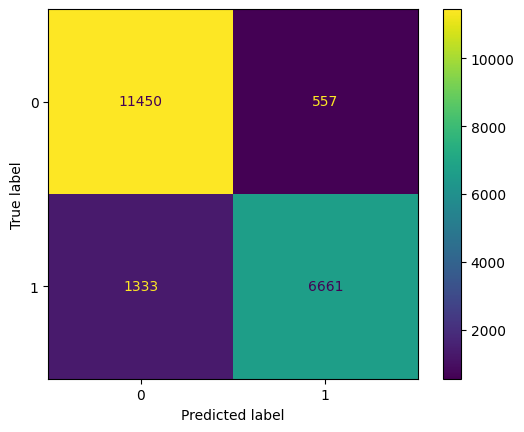

In [13]:
m.ConfusionMatrixDisplay(m.confusion_matrix(test_labels, predictions)).plot()

In [14]:
import pickle
with open('trained_models/rf.pkl','wb') as f:
    pickle.dump(rf,f)
print("Model dump complete!")

Model dump complete!
